In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torch.nn as nn
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from torch.utils.data import Dataset, DataLoader
from skimage import io,transform
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
import torchvision
import matplotlib.pyplot as plt


Only used one to filter out all images that couldnt be read

In [0]:
'''import os
df = pd.read_csv('/content/drive/My Drive/Resonance/GenreData.csv')
l = []
root_dir = '/content/drive/My Drive/Resonance/Images'
print(len(df))
new_df = df.copy()
for i in range(len(list(df.iloc[:,0]))):
  spec_name = 'Num.'+str(df.iloc[i,0])+'.jpg'
  img_name = os.path.join(root_dir,spec_name)
  try: 
    io.imread(img_name)
  except:
    new_df = new_df.drop(i)
print(len(new_df))
new_df.to_csv('/content/drive/My Drive/Resonance/GenreData.csv',index=False)'''

1253
1239


In [0]:
import os
from PIL import Image

class ImageDataset(Dataset):
  def __init__(self,df,d):
    self.df = df
    self.d = d
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self,idx):
    dict_ind = self.df.iloc[idx,0]
    image = self.d[dict_ind]
    ydata = self.df.iloc[idx,1:]
    ydata = np.array(ydata)
    ydata = ydata.astype(float).reshape(-1,1)
    return image,ydata


Different pytorch transformations. transform_f and transform_r are used for data augmentation

In [0]:
df = pd.read_csv('/content/drive/My Drive/Resonance/GenreData.csv')
root_dir = '/content/drive/My Drive/Resonance/Images'

transform = transforms.Compose([transforms.Resize((64,64)),
        transforms.ToTensor(),transforms.Normalize(mean=[.5,.5,.5],
                             std=[.5,.5,.5])])
transform_f = transforms.Compose([transforms.Resize((64,64)),
        transforms.RandomHorizontalFlip(p=1),
        transforms.ToTensor(),transforms.Normalize(mean=[.5,.5,.5],
                             std=[.5,.5,.5])])
transform_r = transforms.Compose([transforms.Resize((64,64)),
        transforms.RandomRotation(45),
        transforms.ToTensor(),transforms.Normalize(mean=[.5,.5,.5],
                             std=[.5,.5,.5])])


Read all images into a dictionary where keys are image name. Having them all loaded in significantly speeds up net training time, and doesnt take up much space after transformation

In [0]:
images64 = {}
for idx in range(len(df)):
  spec_name = 'Num.'+str(df.iloc[idx,0])+'.jpg'
  img_name = os.path.join(root_dir,spec_name)
  image = Image.open(img_name).convert('RGB')
  image64 = transform(image)
  images64[df.iloc[idx,0]] = image64

In [0]:
train_images = {}
train,test = train_test_split(df,test_size=.2,random_state=2) 
for idx in range(len(train)):
  num = train.iloc[idx,0]
  num = int(num)
  spec_name = 'Num.'+str(num)+'.jpg'
  img_name = os.path.join(root_dir,spec_name)
  image = Image.open(img_name).convert('RGB')
  image_n = transform(image)
  image_f = transform_f(image)
  image_r = transform_r(image)
  train.loc[str(num)+'r'] = [str(num)+'r']+list(train.iloc[idx,1:])
  train.loc[str(num)+'f'] = [str(num)+'f']+list(train.iloc[idx,1:])

  train_images[train.iloc[idx,0]] = image_n
  train_images[str(num)+'f'] = image_f
  train_images[str(num)+'r'] = image_r
train = ImageDataset(train,train_images)
test = ImageDataset(test,images64)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Make sure loader sizes are correct

In [0]:
for i_batch, (image,y) in enumerate(train_loader):
    print(i_batch, image.size(),
          y.size())
    test1 = y
    if i_batch ==5:
      test1 = image
      break

    # observe 4th batch and stop.

0 torch.Size([4, 3, 64, 64]) torch.Size([4, 14, 1])
1 torch.Size([4, 3, 64, 64]) torch.Size([4, 14, 1])
2 torch.Size([4, 3, 64, 64]) torch.Size([4, 14, 1])
3 torch.Size([4, 3, 64, 64]) torch.Size([4, 14, 1])
4 torch.Size([4, 3, 64, 64]) torch.Size([4, 14, 1])
5 torch.Size([4, 3, 64, 64]) torch.Size([4, 14, 1])


Train net

In [0]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
import torch.nn as nn


class GenreNet(nn.Module): 
    def __init__(self):
        super(GenreNet, self).__init__()
        #feed forward layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2,stride=2)            
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.dropout = nn.Dropout()
        self.linear1 = nn.Linear(32*16*16,1000)
        self.linear2 = nn.Linear(1000,500)
        self.linear3 = nn.Linear(500,100)
        self.linear4 = nn.Linear(100,14)
        
        
        #activations
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid() #Use sigmoid to convert the output into range (0,1)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        #out = self.layer2(out)
        #out = self.layer2(out)
        out = out.reshape(out.size(0),-1)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        out = self.relu(out)
        out = self.linear4(out)
        return out
torch.manual_seed(0)
net=GenreNet()

#opt=torch.optim.SGD(net.parameters(),lr=1e-2,nesterov=True,momentum=.2)
opt = torch.optim.Adam(net.parameters(),lr=1e-3,weight_decay=.001)

'''@torch.no_grad()
def init_weights(m):
    if type(m)==nn.Linear:
        m.weight.fill_(0)
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        #nn.init.xavier_uniform_(m.bias.data)
net.apply(init_weights)'''


loss = nn.BCEWithLogitsLoss()

train_loader = DataLoader(train, batch_size=96,
                        shuffle=True, num_workers=4,drop_last=True)

loss_list = []
f1_list = []
test_loss = []
total_step = len(train_loader)
num_epochs = 30
i = 0
test_loader = DataLoader(test, batch_size=len(test),
                        num_workers=4)
from sklearn.metrics import f1_score, precision_score, recall_score
for epoch in range(num_epochs):
  print('epoch',epoch)
  i = 0 
  for i,(image,labels) in enumerate(test_loader):
    outputs = net(image)
    labels = labels.reshape(248,14)
    l = loss(outputs,labels)
    test_loss.append(l.item())
    predicted = torch.sigmoid(outputs.data) > .5
    f1 = f1_score(labels.to('cpu'),predicted.to('cpu'),average='samples')
    prec = precision_score(labels.to('cpu'),predicted.to('cpu'),average='samples')
    print('TEST LOSS:',l.item(),'TEST F1:',f1,'PREC SCORE:',prec)
  for i,(image,labels) in enumerate(train_loader):
    i+=1
    print('batch',i)
    outputs = net(image)
    labels = labels.reshape(96,14)
    l = loss(outputs,labels)
    loss_list.append(l.item())

    opt.zero_grad()
    l.backward()
    opt.step()

    total = labels.size(0)
    predicted = torch.sigmoid(outputs.data) > .5
    f1 = f1_score(labels.to('cpu'),predicted.to('cpu'),average='samples')
    f1_list.append(f1)

    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, F1: {:.2f}%'
          .format(epoch + 1, num_epochs, i + 1, total_step, l.item(),
                  f1) * 100)

If you want to continue training past original epoch number

In [0]:
num_epochs = 5
for epoch in range(num_epochs):
  print('epoch',epoch)
  i = 0
  for i,(image,labels) in enumerate(test_loader):
    outputs = net(image)
    labels = labels.reshape(248,14)
    l = loss(outputs,labels)
    predicted = torch.sigmoid(outputs.data) > .5
    f1 = f1_score(labels.to('cpu'),predicted.to('cpu'),average='samples')
    print('TEST LOSS:',l.item(),'TEST F1:',f1)
  for i,(image,labels) in enumerate(train_loader):
    i+=1
    print('batch',i)
    outputs = net(image)
    labels = labels.reshape(96,14)
    l = loss(outputs,labels)
    loss_list.append(l.item())

    opt.zero_grad()
    l.backward()
    opt.step()

    total = labels.size(0)
    predicted = torch.sigmoid(outputs.data) > .5
    f1 = f1_score(labels.to('cpu'),predicted.to('cpu'),average='samples')
    f1_list.append(f1)

    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, F1: {:.2f}%'
          .format(epoch + 1, num_epochs, i + 1, total_step, l.item(),
                  f1) * 100)

Save net. Also very important to save net class to nets.py

In [0]:
torch.save(net, '/content/drive/My Drive/Resonance/GenreNet.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GenreNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
from nets import GenreNet

In [0]:
net = torch.load('/content/drive/My Drive/Resonance/GenreNet.pt')

In [0]:
from sklearn.metrics import precision_score, recall_score

In [0]:
from sklearn.metrics import f1_score
test_loader = DataLoader(test, batch_size=len(test),
                        num_workers=4)
for i,(image,labels) in enumerate(test_loader):
  outputs = net(image)
  labels = labels.reshape(248,14)
  predicted = torch.sigmoid(outputs.data) > .7
  f1 = f1_score(labels.to('cpu'),predicted.to('cpu'),average='micro')

In [0]:
f1

0.5714285714285714

In [0]:
precision_score(labels.to('cpu'),predicted.to('cpu'),average='micro')

0.7582417582417582

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


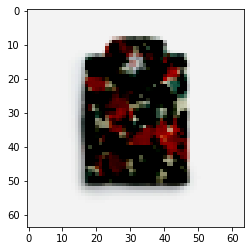

In [0]:
npimg = image.numpy()[7]
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [0]:
def inspect(num):
  npimg = image.numpy()[num]
  plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
  t = pd.DataFrame(outputs.data.numpy()[num]).sort_values(0)
  t['Color'] = cmatch['Unnamed: 0']
  print(labels[num].item())
  print('label',list(codes.loc[codes['0']==labels[num].item()]['Unnamed: 0'])[0])
  print('pred',list(codes.loc[codes['0']==predicted[num].item()]['Unnamed: 0'])[0])
  return t